In [1]:
import sys
sys.path.append("../")

import sqlite3
import numpy as np

from src.cmesrc.config import CMESRC_DB
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib widget

In [2]:
con = sqlite3.connect(CMESRC_DB)
con.execute("PRAGMA foreign_keys = ON")
cur = con.cursor()

In [7]:
cur.execute("SELECT londtmax FROM harps_bbox")

londtmax = [lon[0] for lon in cur.fetchall()]
len(londtmax)

2628572

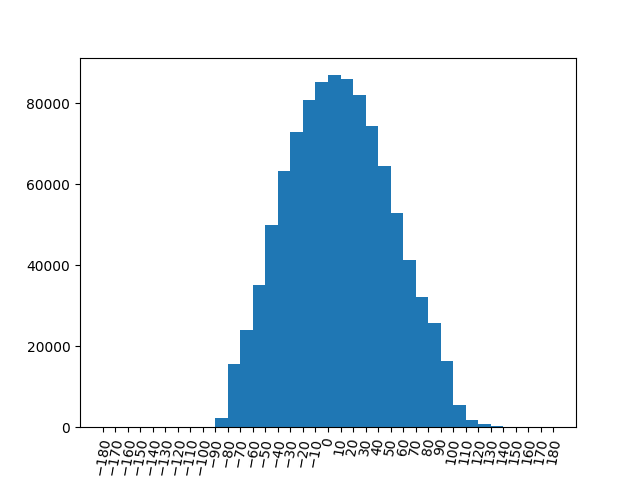

In [18]:
fig, ax = plt.subplots()

# Select random sample of 1000
data = np.random.choice(londtmax, 1000000)

bins = np.arange(-180, 181, 10)

ax.hist(data, bins=bins)

ax.set_xticks(bins)

# Make labels tilted

for tick in ax.get_xticklabels():
    tick.set_rotation(80)

### Let's say only bounding boxes within the -30 and 30 range

In [33]:
# cur.execute("DROP TABLE IF EXISTS overlaps")
# cur.execute("""
# CREATE TEMP TABLE IF NOT EXISTS overlaps AS
# SELECT * FROM distance_matrix dm
# WHERE dm.dist = 0
# AND (dm.harpnum1, dm.timestamp) IN (
#     SELECT hb.harpnum, hb.timestamp FROM harps_bbox hb
#     WHERE hb.londtmin > -70  AND hb.londtmax < 70
#     )
# AND (dm.harpnum2, dm.timestamp) IN (
#     SELECT hb.harpnum, hb.timestamp FROM harps_bbox hb
#     WHERE hb.londtmin > -70  AND hb.londtmax < 70
#     )
# """)

MIN_LON = -30
MAX_LON = 30

cur.execute("DROP TABLE IF EXISTS overlaps")
cur.execute(f"""
CREATE TEMP TABLE IF NOT EXISTS overlaps AS
SELECT dm.* FROM distance_matrix dm
JOIN harps_bbox hb1 ON dm.harpnum1 = hb1.harpnum AND dm.timestamp = hb1.timestamp
JOIN harps_bbox hb2 ON dm.harpnum2 = hb2.harpnum AND dm.timestamp = hb2.timestamp
WHERE dm.dist = 0 AND hb1.londtmin > {MIN_LON} AND hb1.londtmax < {MAX_LON} AND hb2.londtmin > {MIN_LON} AND hb2.londtmax < {MAX_LON};
""")

cur.execute("SELECT * FROM overlaps LIMIT 1")
print(cur.fetchone())

(23, 25, '2010-05-20 13:48:00', 0.0)


In [36]:
cur.execute("SELECT harpnum1, harpnum2, timestamp FROM overlaps")
overlaps = cur.fetchall()

for overlap in overlaps:
    harpnum1, harpnum2, timestamp = overlap

    cur.execute("SELECT londtmin, londtmax FROM harps_bbox WHERE harpnum = ? AND timestamp = ?", (harpnum1, timestamp))

    harp1 = cur.fetchone()

    cur.execute("SELECT londtmin, londtmax FROM harps_bbox WHERE harpnum = ? AND timestamp = ?", (harpnum2, timestamp))

    harp2 = cur.fetchone()

    harp1_min_long, harp1_max_long = harp1
    harp2_min_long, harp2_max_long = harp2

    if (harp1_min_long < MIN_LON) or (harp1_max_long > MAX_LON):
        print(f"Error: {harpnum1} at {timestamp} longitude is {harp1_min_long} to {harp1_max_long}")

    if (harp2_min_long < MIN_LON) or (harp2_max_long > MAX_LON):
        print(f"Error: {harpnum2} at {timestamp} longitude is {harp2_min_long} to {harp2_max_long}")


In [37]:
cur.execute("DROP TABLE IF EXISTS clusters")
cur.execute("""
CREATE TABLE IF NOT EXISTS clusters (
    harpnum INTEGER UNIQUE NOT NULL REFERENCES harps (harpnum),
    cluster_id INTEGER NOT NULL,
    PRIMARY KEY (harpnum)
)
""")

In [38]:
cur.execute("""
SELECT DISTINCT harpnum1, harpnum2 FROM overlaps;
""")

overlaps = cur.fetchall()

i = 0
for row in tqdm(overlaps):
    harpnum1, harpnum2 = row

    cur.execute("""
    SELECT cluster_id FROM clusters WHERE harpnum = ?;
    """, (harpnum1,))

    cluster_id1 = cur.fetchone()
    if cluster_id1 is None:
        cluster_id1 = i
        cur.execute("""
        INSERT INTO clusters (harpnum, cluster_id) VALUES (?, ?);
        """, (harpnum1, cluster_id1))
        i += 1
    else:
        cluster_id1 = cluster_id1[0]

    cur.execute("""
    SELECT cluster_id FROM clusters WHERE harpnum = ?;
    """, (harpnum2,))

    cluster_id2 = cur.fetchone()
    if cluster_id2 is None:
        cluster_id2 = i
        cur.execute("""
        INSERT INTO clusters (harpnum, cluster_id) VALUES (?, ?);
        """, (harpnum2, cluster_id2))
        i += 1
    else:
        cluster_id2 = cluster_id2[0]

    if cluster_id1 != cluster_id2:
        cur.execute("""
        UPDATE clusters SET cluster_id = ? WHERE cluster_id = ?;
        """, (cluster_id1, cluster_id2))

100%|██████████| 652/652 [00:00<00:00, 58601.26it/s]


In [39]:
con.commit()

## Things below were done with pixel bbox, I've change to physical bbox distances

So, the issue is simple. When BBOXES get close to the limb they will overlap a lot even if on disk centre they didnt. So to cluster regions we need to consider them in disk centre. Let's say +- 70 degrees longitude

In [ ]:
# Select only timestamps from harps_bbox where the average value of londtmin and londtmax is within -70 and 70
cur.execute("SELECT harpnum, timestamp FROM harps_bbox WHERE (londtmin + londtmax) / 2 BETWEEN -70 AND 70")

harpnum_timestamps = cur.fetchall()
print(len(harpnum_timestamps))

In [ ]:
cur.execute("""
SELECT COUNT(*) FROM distance_matrix 
WHERE (harpnum1, timestamp) IN (
    SELECT harpnum, timestamp FROM harps_bbox
    WHERE (londtmin + londtmax) / 2 BETWEEN -70 AND 70
    )
AND (harpnum2, timestamp) IN (
    SELECT harpnum, timestamp FROM harps_bbox
    WHERE (londtmin + londtmax) / 2 BETWEEN -70 AND 70
    )
""")
print(f"Number of rows in distance_matrix: {cur.fetchone()[0]}")

In [ ]:
cur.execute("CREATE INDEX IF NOT EXISTS harpnum1_index ON distance_matrix (harpnum1);")
cur.execute("CREATE INDEX IF NOT EXISTS harpnum2_index ON distance_matrix (harpnum2);")
cur.execute("CREATE INDEX IF NOT EXISTS timestamp_index ON distance_matrix (timestamp);")
con.commit()

In [ ]:
MIN_DIST = 5 ** 2
cur.execute("""
SELECT COUNT(*) FROM distance_matrix
WHERE dist < ?
AND (harpnum1, timestamp) IN (
    SELECT harpnum, timestamp FROM harps_bbox
    WHERE (londtmin + londtmax) / 2 BETWEEN -70 AND 70
    )
AND (harpnum2, timestamp) IN (
    SELECT harpnum, timestamp FROM harps_bbox
    WHERE (londtmin + londtmax) / 2 BETWEEN -70 AND 70
    )
""", (MIN_DIST,))
print(f"Number of rows in distance_matrix with distance < {np.sqrt(MIN_DIST)}: {cur.fetchone()[0]}")

In [ ]:
cur.execute("DROP TABLE IF EXISTS overlaps")
cur.execute("""
CREATE TEMP TABLE IF NOT EXISTS overlaps AS
SELECT * FROM distance_matrix dm
WHERE dm.dist < ?
AND (dm.harpnum1, dm.timestamp) IN (
    SELECT hb.harpnum, hb.timestamp FROM harps_bbox hb
    WHERE (hb.londtmin + hb.londtmax) / 2 BETWEEN -70 AND 70
    )
AND (dm.harpnum2, dm.timestamp) IN (
    SELECT hb.harpnum, hb.timestamp FROM harps_bbox hb
    WHERE (hb.londtmin + hb.londtmax) / 2 BETWEEN -70 AND 70
    )
""", (MIN_DIST,))

In [28]:
cur.execute("SELECT harpnum1, harpnum2, timestamp FROM overlaps")
overlaps = cur.fetchall()

for overlap in overlaps:
    harpnum1, harpnum2, timestamp = overlap

    cur.execute("SELECT londtmin, londtmax FROM harps_bbox WHERE harpnum = ? AND timestamp = ?", (harpnum1, timestamp))

    harp1 = cur.fetchone()

    cur.execute("SELECT londtmin, londtmax FROM harps_bbox WHERE harpnum = ? AND timestamp = ?", (harpnum2, timestamp))

    harp2 = cur.fetchone()

    harp1_mean_long = (harp1[0] + harp1[1]) / 2
    harp2_mean_long = (harp2[0] + harp2[1]) / 2

    if (harp1_mean_long < -70) or (harp1_mean_long > 70):
        print(f"Error: {harpnum1} at {timestamp} mean longitude is {harp1_mean_long}")

    if (harp2_mean_long < -70) or (harp2_mean_long > 70):
        print(f"Error: {harpnum2} at {timestamp} mean longitude is {harp2_mean_long}")

In [ ]:
con.commit()

In [ ]:
cur.execute("DROP TABLE IF EXISTS clusters")
cur.execute("""
CREATE TABLE IF NOT EXISTS clusters (
    harpnum INTEGER UNIQUE NOT NULL REFERENCES harps (harpnum),
    cluster_id INTEGER NOT NULL,
    PRIMARY KEY (harpnum)
)
""")

In [ ]:
cur.execute("""
SELECT DISTINCT harpnum1, harpnum2 FROM overlaps;
""")

overlaps = cur.fetchall()

i = 0
for row in tqdm(overlaps):
    harpnum1, harpnum2 = row

    cur.execute("""
    SELECT cluster_id FROM clusters WHERE harpnum = ?;
    """, (harpnum1,))

    cluster_id1 = cur.fetchone()
    if cluster_id1 is None:
        cluster_id1 = i
        cur.execute("""
        INSERT INTO clusters (harpnum, cluster_id) VALUES (?, ?);
        """, (harpnum1, cluster_id1))
        i += 1
    else:
        cluster_id1 = cluster_id1[0]

    cur.execute("""
    SELECT cluster_id FROM clusters WHERE harpnum = ?;
    """, (harpnum2,))

    cluster_id2 = cur.fetchone()
    if cluster_id2 is None:
        cluster_id2 = i
        cur.execute("""
        INSERT INTO clusters (harpnum, cluster_id) VALUES (?, ?);
        """, (harpnum2, cluster_id2))
        i += 1
    else:
        cluster_id2 = cluster_id2[0]

    if cluster_id1 != cluster_id2:
        cur.execute("""
        UPDATE clusters SET cluster_id = ? WHERE cluster_id = ?;
        """, (cluster_id1, cluster_id2))

In [ ]:
cur.execute("SELECT cluster_id, COUNT(*) FROM clusters GROUP BY cluster_id LIMIT 20;")
print(cur.fetchall())

In [ ]:
con.commit()

In [ ]:
cur.execute("SELECT DISTINCT harpnum1, harpnum2 FROM overlaps;")

overlaps = cur.fetchall()

cur.execute("SELECT harpnum FROM harps;")

all_harpnums = [harpnum[0] for harpnum in cur.fetchall()]

# Now create a adjacency matrix

adjacency_matrix = np.zeros((len(all_harpnums), len(all_harpnums)))

harps_idx = {harpnum: i for i, harpnum in enumerate(all_harpnums)}

for row in tqdm(overlaps):
    harpnum1, harpnum2 = row

    i = harps_idx[harpnum1]
    j = harps_idx[harpnum2]

    adjacency_matrix[i, j] = 1
    adjacency_matrix[j, i] = 1

# Fill the diagonal with 1
np.fill_diagonal(adjacency_matrix, 0)

In [ ]:
# Test it's symmetric and square

assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1]
assert np.allclose(adjacency_matrix, adjacency_matrix.T)

In [ ]:
import pandas as pd
import networkx as nx
import community

adj_matrix = adjacency_matrix.copy()

# Build the graph
G = nx.Graph(adj_matrix)
G = nx.relabel_nodes(G, harps_idx)

nodes_connected = [node for node, degree in G.degree() if degree > 1]

G_connected = G.subgraph(nodes_connected)

fig, ax = plt.subplots()

pos = nx.kamada_kawai_layout(G_connected)
nx.draw(G_connected, pos, with_labels=False, ax=ax)



In [ ]:
cur.execute("SELECT timestamp from images;")
timestamps = [timestamp[0] for timestamp in cur.fetchall()]

In [ ]:
cur.execute("SELECT harpnum FROM harps;")
harps = [harp[0] for harp in cur.fetchall()]

In [ ]:
cur.execute("CREATE INDEX IF NOT EXISTS dist_index ON overlaps (dist);")
cur.execute("CREATE INDEX IF NOT EXISTS timestamp_index ON overlaps (timestamp);")
cur.execute("CREATE INDEX IF NOT EXISTS harpnum1 ON overlaps (timestamp);")
cur.execute("CREATE INDEX IF NOT EXISTS harpnum2 ON overlaps (timestamp);")

In [ ]:
cur.execute("""
DROP TABLE IF EXISTS cluster_contents;
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS cluster_contents (
    cluster_id INTEGER,
    harpnum INTEGER,
    PRIMARY KEY (harpnum)
    );
""")

cur.execute("""
DROP TABLE IF EXISTS closest_pairs;
""")

cur.execute("""
CREATE TEMP TABLE IF NOT EXISTS closest_pairs (
    harpnum1 INTEGER UNIQUE NOT NULL,
    harpnum2 INTEGER UNIQUE NOT NULL,
    PRIMARY KEY (harpnum1, harpnum2)
    );
""")

con.commit()

In [ ]:
tempcur = con.cursor()

dist_matrix = 512 ** 2 * np.ones((len(harps), len(harps)))

harps_indices = {harps: i for i, harps in enumerate(harps)}

min_distances = cur.execute("SELECT harpnum1, harpnum2, MIN(dist) AS min_dist FROM overlaps GROUP BY harpnum1, harpnum2")

for row in tqdm(min_distances):
    harpnum1, harpnum2, min_dist = row
    dist_matrix[harps_indices[harpnum1], harps_indices[harpnum2]] = min_dist

In [ ]:
plot_matrix = 512 - np.sqrt(dist_matrix)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

small_plot_matrix = plot_matrix[2000:2100, 2000:2100]

# Plot the plot_matrix as a 3d bar plot, but don't plot where the value is 0

x, y = np.meshgrid(np.arange(small_plot_matrix.shape[0]), np.arange(small_plot_matrix.shape[1]))

x = x.flatten()
y = y.flatten()
z = np.zeros(x.shape)

dx = 1 * np.ones_like(z)
dy = dx.copy()
dz = small_plot_matrix.flatten()

# Don't plot where the value is 0
x = x[dz != 0]
y = y[dz != 0]
z = z[dz != 0]
dx = dx[dz != 0]
dy = dy[dz != 0]
dz = dz[dz != 0]

ax.bar3d(x, y, z, dx, dy, dz)


ax.set_xlabel("HARPNUM")

In [ ]:
import numpy as np
clustering_matrix = 512 - np.sqrt(dist_matrix)
clustering_matrix = np.maximum(clustering_matrix, clustering_matrix.T)
clustering_matrix = 512 - clustering_matrix
np.fill_diagonal(clustering_matrix, 0)
clustering_matrix[:10, :10]

In [ ]:
from scipy.spatial.distance import squareform
from sklearn.cluster import DBSCAN

copy_clustering_matrix = clustering_matrix.copy()

threshold = MIN_DIST
copy_clustering_matrix[copy_clustering_matrix > threshold] = 1000
copy_clustering_matrix[copy_clustering_matrix <= threshold] = 0

dist_vector = squareform(copy_clustering_matrix)

db = DBSCAN(eps=threshold, min_samples=1, metric='precomputed')

X = dist_vector.reshape(-1, 1)

labels = db.fit_predict(copy_clustering_matrix)

In [ ]:
cur.execute("SELECT * FROM cluster_contents;")

print(cur.fetchall())

In [ ]:
for label, harpnum in zip(labels, harps):
    cur.execute("INSERT INTO cluster_contents VALUES (?, ?)", (int(label), int(harpnum)))

con.commit()

In [ ]:
con.close()

In [ ]:
region_labels[region_labels != 0]